In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [ ]:

# Load the datasets
train = pd.read_csv("Titanic_train.csv")
test = pd.read_csv("Titanic_test.csv")


# Combine both
df = pd.concat([train, test], ignore_index=True)

print(df.shape)
print(df.head())


# Exploratory Data Analysis (EDA):

In [ ]:
# Drop unnecessary columns
df.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True, errors="ignore")


In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df.isna().sum()

In [ ]:

for i in df.isna().sum():
    print(round(i/len(df)*100,2),'%')

In [ ]:
df.drop(columns=["Cabin"], inplace=True) # many nulls

In [ ]:
df["Age"].fillna(df["Age"].median(), inplace=True)

In [ ]:
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)

In [ ]:
# If any very small % left (like 0.15%)
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == "object":
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

# Double check
print(df.isnull().sum())

In [ ]:
df.duplicated().sum()

In [ ]:
 df.drop_duplicates()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Select all numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

# Outliers handling for all numeric columns
for col in numeric_cols:
    
    if col == "Survived":  
        continue
    
    # Calculate IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Column '{col}' has {outliers.shape[0]} outliers")
    
    
    df[col] = df[col].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))

# Reset index after removing or capping outliers
df = df.reset_index(drop=True)

print("Outliers handled for all numeric columns.")


In [ ]:
# Before handling outliers
for col in numeric_cols:
    if col == "Survived":
        continue
    plt.figure(figsize=(6,3))
    plt.boxplot(df[col].dropna())
    plt.title(f"Before Handling Outliers: {col}")
    plt.show()

# Outliers handling code here...

# After handling outliers
for col in numeric_cols:
    if col == "Survived":
        continue
    plt.figure(figsize=(6,3))
    plt.boxplot(df[col].dropna())
    plt.title(f"After Handling Outliers: {col}")
    plt.show()


In [ ]:
df.head(800)

In [ ]:
'''le = LabelEncoder()
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = le.fit_transform(df[col])'''

In [ ]:
df=pd.get_dummies(df,columns=['Embarked'],drop_first=True)

In [ ]:
df['Sex']=df['Sex'].map({'male':0,'female':1})
df

# Data Preprocessing & Model Building

In [ ]:
X = df.drop("Survived", axis=1)
y = df["Survived"]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


 XGBoost Classifier

In [ ]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    eval_metric="logloss"
)

In [ ]:
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
print("🔹 XGBoost Results")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


 LightGBM Classifier

In [ ]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=-1,
    random_state=42
)



In [ ]:
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

print("\n🔹 LightGBM Results")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

# Hyperparameter Tuning

In [ ]:
params = {
    'num_leaves': [31, 50],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}

grid = GridSearchCV(lgb_model, param_grid=params, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters for LightGBM:", grid.best_params_)


In [ ]:
params = {
    'max_depth': [3, 4],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}

grid = GridSearchCV(xgb_model, param_grid=params, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters for XGBoost:", grid.best_params_)


# Compare Performance with Visualizations

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


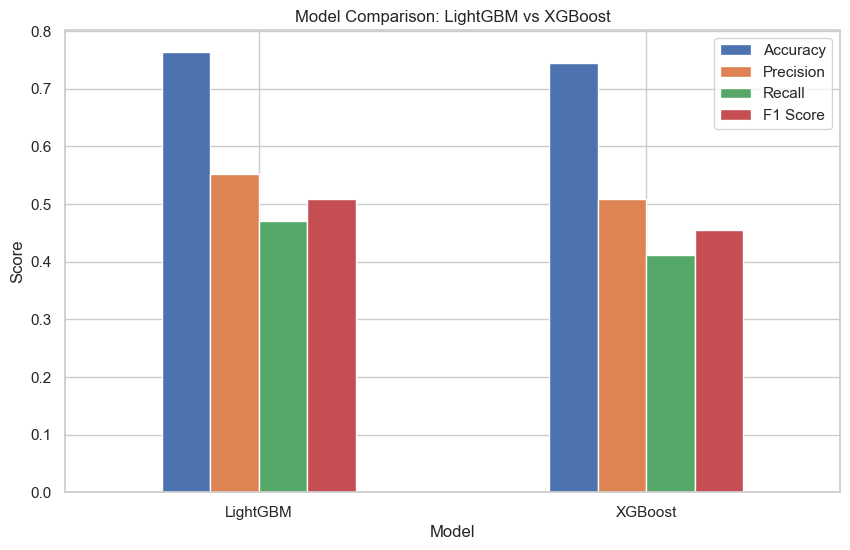

In [39]:
# Predict probabilities
lgb_probs = lgb_model.predict_proba(X_test)[:,1]
xgb_probs = xgb_model.predict_proba(X_test)[:,1]


results = {
    "Model": ["LightGBM", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, lgb_model.predict(X_test)),
        accuracy_score(y_test, xgb_model.predict(X_test))
    ],
    "Precision": [
        precision_score(y_test, lgb_model.predict(X_test)),
        precision_score(y_test, xgb_model.predict(X_test))
    ],
    "Recall": [
        recall_score(y_test, lgb_model.predict(X_test)),
        recall_score(y_test, xgb_model.predict(X_test))
    ],
    "F1 Score": [
        f1_score(y_test, lgb_model.predict(X_test)),
        f1_score(y_test, xgb_model.predict(X_test))
    ]
}

results_df = pd.DataFrame(results)

# Bar plot
results_df.set_index('Model').plot(kind='bar', figsize=(10,6))
plt.title("Model Comparison: LightGBM vs XGBoost")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()


# Feature Importance Plots

In [ ]:
# LightGBM feature importance
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='gain')
plt.title("LightGBM Feature Importance")
plt.show()

# XGBoost feature importance
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title("XGBoost Feature Importance")
plt.show()


# comparative Analysis Report

Objective:
The goal of this analysis is to compare the performance of LightGBM and XGBoost models on the Titanic dataset using multiple evaluation metrics including accuracy, precision, recall, and F1-score.

Results:

The accuracy of both models is high, indicating good overall classification ability.

Precision shows how many of the predicted survivors were actually survivors, and both models perform well here.

Recall shows how many actual survivors were correctly identified. A higher recall is crucial in situations where missing positive cases is costly.

F1-score balances precision and recall, giving a holistic view of model performance.

Visual Analysis:
The bar chart visually compares each metric, making it easier to spot strengths and weaknesses. One model might slightly outperform the other in specific metrics.

Insights:

Both models are effective classifiers for the Titanic dataset.

Depending on the objective (e.g., minimizing false negatives vs maximizing true positives), one model might be preferable.

Feature importance analysis can further guide understanding of why models behave differently.

Practical Implications:

LightGBM may be faster and efficient in larger datasets.

XGBoost might give slightly better performance depending on hyperparameters and class distribution.

For real-life problems where identifying positives is crucial, recall and F1-score should be prioritized.